# Concurrent execution

The two main modules in Python Standard Library for parallelizing code are `threading` and `multiprocessing`. When deciding between the two, you should ask yourself: what kind of program are you trying to paralellize?
* I/O bound program -> `threading`
* CPU bound program -> `multiprocessing`

## `threading`

A thread is a separate flow of execution. This means that your program will have multiple things happening at once. But for most Python implementations the different threads do not actually execute at the same time: they merely appear to. In CPython, multi-threading is supported by introducing the Global Interpreter Lock (GIL) which to prevent multiple threads from accessing the same Python object simultaneously. Only one thread can hold the GIL at a time, one thread must wait for another thread to release the GIL before running.
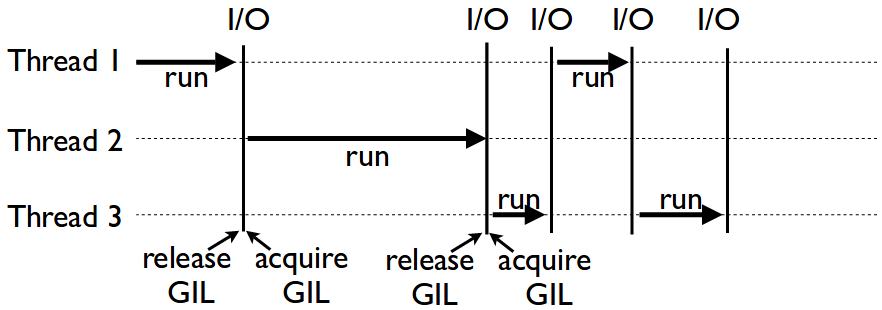

### Using `threading` module

#### `threading.Thread` class
* Represents an activity that is run in a separate thread of control
* Activity can be specified by passing a callable to constructor or by overriding run() method in a subclass
* Activity should be started by calling start() method of Thread instance
* Threads can be named by setting `name` attribute
* `start()` – Starts thread activity. Can be called only one time for a thread. It launches threads’s `run()` method in a separate thread of control
* `run()` – Method representind threads’s activity. Defaults to callable passed in constructor as `target` parameter
* `join([timeout])` – Blocking call that waits for specific thread to terminate
* `is_alive()` – Queries thread status. Returns `True` unitl `run()` method terminates


In [5]:
import threading
import time


def func(nr):
    time.sleep(3)
    print("Finished execution from thread {}".format(nr))


time_start = time.time()
threads = set()

for i in range(1, 6):
    t = threading.Thread(target=func, args=(i, ))
    t.start()
    
    print('Thread {} alive status: {}'.format(t.name, t.is_alive()))

    count = threading.active_count()
    print("Total no of threads: {}".format(count))

    threads.add(t)

for thread in threads:
    thread.join()

time_end = time.time()
total_time = time_end - time_start
print(f'Total time: {total_time:.10f}')

Thread Thread-20 alive status: True
Total no of threads: 6
Thread Thread-21 alive status: True
Total no of threads: 7
Thread Thread-22 alive status: True
Total no of threads: 8
Thread Thread-23 alive status: True
Total no of threads: 9
Thread Thread-24 alive status: True
Total no of threads: 10
Finished execution from thread 1Finished execution from thread 2Finished execution from thread 3Finished execution from thread 4Finished execution from thread 5




Total time: 3.0086216927


A common problem that arises when working with multi-threaded programs is accessing a shared object. If threads need to modify an object, they have to make several operations: get the current value of the object, compute the new value, overwrite object with new value. Between these operations, the thread might pass the run context to another thread, which will read the same "current" version of the common object. When writing to the shared object, both threads will write the same value, leading to one of the computations being lost. 

A way to prevent this is by using a `Lock`. A `Lock` is an object that acts like a hall pass. Only one thread at a time can have the `Lock`. Any other thread that wants the `Lock` must wait until the owner of the `Lock` gives it up.

The basic functions to do this are `.acquire()` and `.release()`. A thread will call `my_lock.acquire()` to get the lock. If the lock is already held, the calling thread will wait until it is released. 

In [9]:
import threading
import time

total = 0
lock = threading.Lock()


def update_total(amount):
    """
    Updates the total by the given amount
    """
    global total

    with lock:
        for _ in range(1000000):
            total += amount
            
            # thread gets current value from `total`
            # computes `curr_val` + `amount`
            # sets new value to `total`
            
    print(total)


if __name__ == '__main__':
    start_time = time.time()
    threads = []
    for _ in range(10):
        my_thread = threading.Thread(target=update_total, args=(1,))
        my_thread.start()
        threads.append(my_thread)

    for thread in threads:
        thread.join()

    end_time = time.time()
    print('Total', total)
    print(f'Total execution time: {end_time - start_time:.10f}')


1000000
2000000
3000000
4000000
5000000
6000000
7000000
8000000
9000000
10000000
Total 10000000
Total execution time: 1.2358169556


## `multiprocessing`

Multiprocessing allows you to create programs that can run concurrently (bypassing the GIL) and use the entirety of your CPU core. Though it is fundamentally different from the threading library, the syntax is quite similar. The multiprocessing library gives each process its own Python interpreter and each their own GIL.

Because of this, the usual problems associated with threading (such as data corruption and deadlocks) are no longer an issue. Since the processes don't share memory, they can't modify the same memory concurrently.

In [13]:
from multiprocessing import Process, current_process
import time
import random


def doubler(nr):
    """
    A doubling function that can be used by a process
    """
    # Mock time-consuming processing:
    x = 0
    for i in range(1000000):
        x += random.randint(1, 10)

    result = nr * 2
    proc_name = current_process().name
    print('{} doubled to {} by: {}'.format(nr, result, proc_name))


if __name__ == '__main__':
    numbers = [5, 10, 15, 20, 25]
    procs = []

    time0 = time.time()
    for number in numbers:
        proc = Process(target=doubler, args=(number,))
        procs.append(proc)
        proc.start()

    for proc in procs:
        proc.join()

    time1 = time.time()
    print(f'Total execution time (parallel): {time1-time0:.10f}')

    time0 = time.time()

    for number in numbers:
        doubler(number)

    time1 = time.time()
    print(f'Total execution time (serial): {time1 - time0:.10f}')


Total execution time (parallel): 0.1870582104
5 doubled to 10 by: MainProcess
10 doubled to 20 by: MainProcess
15 doubled to 30 by: MainProcess
20 doubled to 40 by: MainProcess
25 doubled to 50 by: MainProcess
Total execution time (serial): 6.5554959774
